## Import raw data, check for missing values and outliers

In [1]:
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
result = pyreadr.read_r('../data/raw/SilvioKlein_Transactions.rdata')
df = list(result.values())[0]

In [3]:
# Store initial memory usage
mem_before = df.memory_usage(deep=True).sum() / 1024**2

# Convert all proposed columns to their optimized dtypes
int_columns = [
    'unit_id', 'property_id', 'housenumber', 'gross_volume', 
    'parcel_surface', 'rooms_nr', 'initial_list_price',
    'last_list_price', 'transaction_price', 'id', 'duration'
]

#float_columns = ['unit_surface', 'construction_yr']

cat_columns = [
    'use_type', 'property_class', 'property_type', 'construction_per',
    'qual_inside', 'qual_outside', 'shed', 'monument', 'place',
    'province', 'addition', 'street', 'pc6'
]

# Convert dtypes
for col in int_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, coercing errors to NaN
    if not pd.api.types.is_integer_dtype(df[col]):
        df[col] = df[col].round().astype('Int64')  # Round and convert to Int64 if necessary
    
#for col in float_columns:
#    df[col] = pd.to_numeric(df[col], errors='coerce').astype('float64')
    
for col in cat_columns:
    df[col] = df[col].astype('category')
    
# Convert date columns
df['date_of_listing'] = pd.to_datetime(df['date_of_listing'])
df['date_of_transaction'] = pd.to_datetime(df['date_of_transaction'])


def repair_integer64(series: pd.Series) -> pd.Series:
    """
    Take a float64 Series whose bit‐patterns actually are 64‐bit ints
    (R’s integer64 got coerced to subnormal float64).  Reinterpret
    the bits as uint64, fix endianness if needed, and return a
    nullable Int64 Series.
    """
    vals = series.to_numpy(dtype="float64")
    mask = ~np.isnan(vals)
    # If these really are the 1e‑321 subnormals…
    if (np.abs(vals[mask]) < 1e-100).all():
        ints = vals.view(np.uint64)
        # detect wrong byte‐order
        if ints[mask].mean() > 10_000:
            ints = vals.byteswap().view(np.uint64)
        out = pd.Series(ints, index=series.index).astype("Int64")
        out[~mask] = pd.NA
        return out
    # otherwise they were real floats → just round
    return series.round().astype("Int64")

# then for your column
df["construction_yr"] = repair_integer64(df["construction_yr"])
df["unit_surface"] = repair_integer64(df["unit_surface"])

# Calculate memory savings
mem_after = df.memory_usage(deep=True).sum() / 1024**2
print(f"\nMemory usage reduced from {mem_before:.1f} MB to {mem_after:.1f} MB")
print(f"Memory savings: {(1 - mem_after/mem_before):.1%}")


Memory usage reduced from 545.8 MB to 63.0 MB
Memory savings: 88.5%


In [4]:
print(df.shape)

(486867, 28)


### Look at missing data

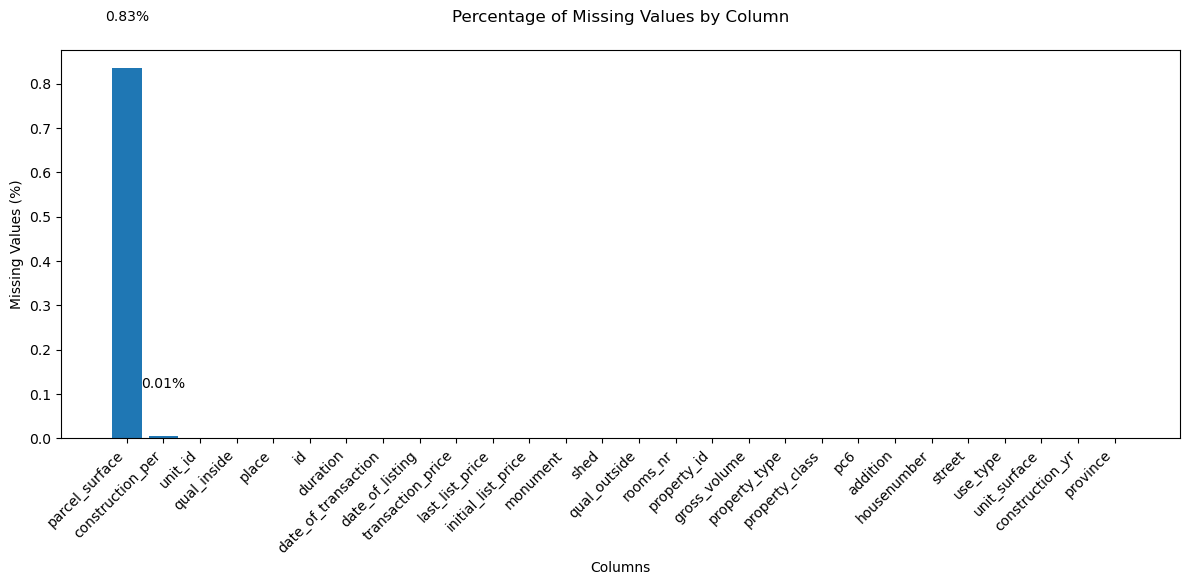

In [6]:
# Calculate missing values percentage
missing_vals = (df.isna().sum() / len(df) * 100).sort_values(ascending=False)

# Create figure and axis
plt.figure(figsize=(12, 6))

# Create bar plot
bars = plt.bar(range(len(missing_vals)), missing_vals)

# Customize the plot
plt.title('Percentage of Missing Values by Column', pad=20)
plt.xlabel('Columns')
plt.ylabel('Missing Values (%)')

# Rotate x-axis labels for better readability
plt.xticks(range(len(missing_vals)), missing_vals.index, rotation=45, ha='right')

# Add percentage annotations above each bar
for i, v in enumerate(missing_vals):
    if v > 0:  # Only annotate if there are missing values
        plt.text(i, v + 0.1, f'{v:.2f}%', 
                 ha='center', va='bottom')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

In [7]:
# Create mask for missing parcel_surface values
missing_mask = df['parcel_surface'].isna()

# Get PC6 distribution for missing values
missing_by_pc6 = df[missing_mask]['pc6'].value_counts()

# Create a DataFrame with count and percentage
missing_analysis = pd.DataFrame({
    'Missing_Count': missing_by_pc6,
    'Total_Count': df.groupby('pc6').size()
})

missing_analysis['Missing_Percentage'] = (missing_analysis['Missing_Count'] / missing_analysis['Total_Count'] * 100).round(2)

# Sort by count of missing values
missing_analysis = missing_analysis.sort_values('Missing_Count', ascending=False)

# Analyze PC6 codes with 100% missing values vs partial missing values
all_missing = missing_analysis[missing_analysis['Missing_Percentage'] == 100]
partial_missing = missing_analysis[missing_analysis['Missing_Percentage'] < 100]

print(f"PC6 codes with 100% missing values: {len(all_missing)}")
print(f"PC6 codes with partial missing values: {len(partial_missing)}")

PC6 codes with 100% missing values: 261
PC6 codes with partial missing values: 75527


/var/folders/gm/q6vshmw56lv20sn76r21877r0000gn/T/ipykernel_73765/1770158247.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'Total_Count': df.groupby('pc6').size()


- The number of missing values for construction_per is extremely low (31, 0.01%). We impute these missing construction_per values from the respective construction_yr for the same properties.
- The number of missing values for parcel_surface (4063, 0.83%) is a bit higher. To avoid deleting the records and keeping a local scale, we do a median impute within the ZIP code. If there are no other observations for parcel_surface within the ZIP code, we impute using the median over the whole dataset. Using single median imputation is supported by Jokobsen et al. (https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-017-0442-1), because missingness is < 1 % for every feature and there is no systematic pattern visible in the missing‑data (as only two columns even have missings).

### Outlier analysis

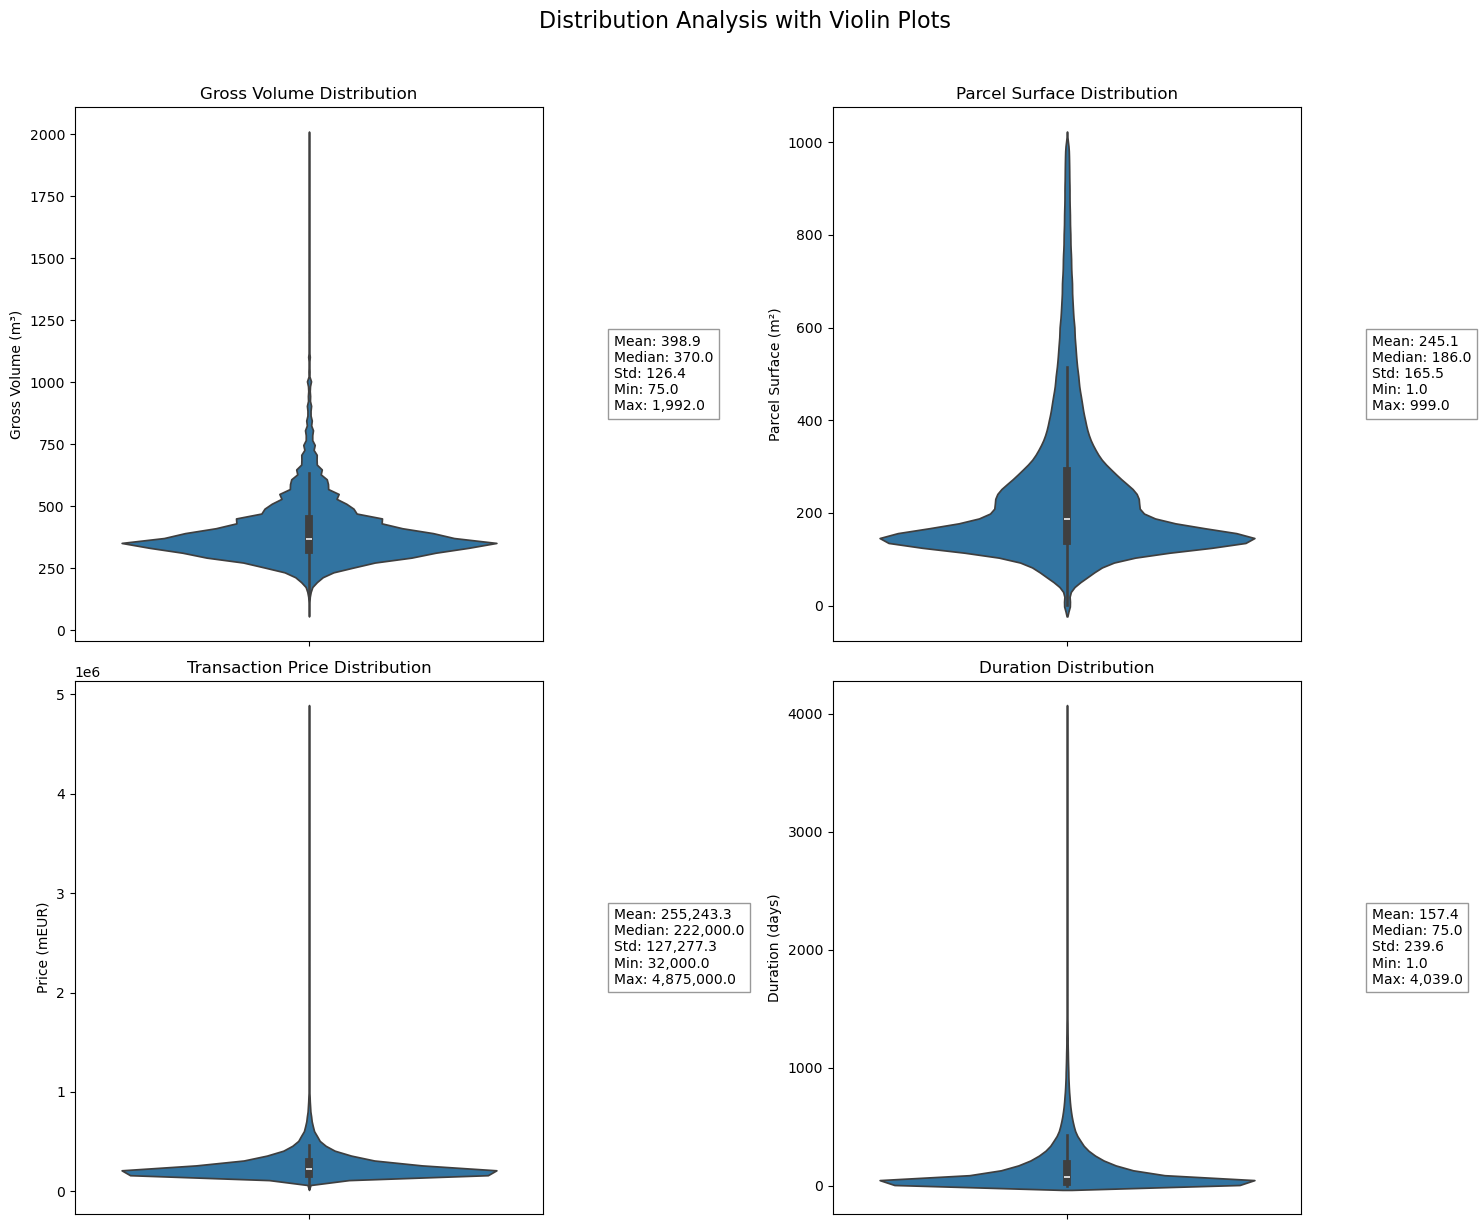


Potential Outlier Thresholds (using 1.5 IQR rule):

gross_volume:
Lower bound: 139.00
Upper bound: 635.00
Number of potential outliers: 24,540 (5.04% of data)

parcel_surface:
Lower bound: -85.00
Upper bound: 515.00
Number of potential outliers: 38,393 (7.89% of data)

transaction_price:
Lower bound: 250.00
Upper bound: 470,250.00
Number of potential outliers: 28,384 (5.83% of data)

duration:
Lower bound: -211.00
Upper bound: 429.00
Number of potential outliers: 39,145 (8.04% of data)


In [8]:
# Create violin plots for numerical columns
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Distribution Analysis with Violin Plots', fontsize=16, y=1.02)

# Create violin plots
sns.violinplot(y=df['gross_volume'], ax=axes[0,0])
axes[0,0].set_title('Gross Volume Distribution')
axes[0,0].set_ylabel('Gross Volume (m³)')

sns.violinplot(y=df['parcel_surface'], ax=axes[0,1])
axes[0,1].set_title('Parcel Surface Distribution')
axes[0,1].set_ylabel('Parcel Surface (m²)')

sns.violinplot(y=df['transaction_price'], ax=axes[1,0])
axes[1,0].set_title('Transaction Price Distribution')
axes[1,0].set_ylabel('Price (mEUR)')

sns.violinplot(y=df['duration'], ax=axes[1,1])
axes[1,1].set_title('Duration Distribution')
axes[1,1].set_ylabel('Duration (days)')

# Add statistics in text boxes
for ax, col in zip(axes.flat, ['gross_volume', 'parcel_surface', 'transaction_price', 'duration']):
    stats = df[col].describe()
    stats_text = (f'Mean: {stats["mean"]:,.1f}\n'
                 f'Median: {stats["50%"]:,.1f}\n'
                 f'Std: {stats["std"]:,.1f}\n'
                 f'Min: {stats["min"]:,.1f}\n'
                 f'Max: {stats["max"]:,.1f}')
    ax.text(1.15, 0.5, stats_text,
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
            verticalalignment='center')

plt.tight_layout()
plt.show()

# Print potential outlier thresholds using IQR method
print('\nPotential Outlier Thresholds (using 1.5 IQR rule):')
for col in ['gross_volume', 'parcel_surface', 'transaction_price', 'duration']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[col][(df[col] < lower_bound) | (df[col] > upper_bound)].count()
    print(f"\n{col}:")
    print(f"Lower bound: {lower_bound:,.2f}")
    print(f"Upper bound: {upper_bound:,.2f}")
    print(f"Number of potential outliers: {outliers:,} ({(outliers/len(df)*100):.2f}% of data)")

In the violin plots we can clearly see that gross_volume, parcel_surface, transaction_price, and duration are all right skewed. The IQR rule is flagging prevalence, not error. While it is distribution-agnostic, it is extremely conservative on skew. In heavy‑tailed economic data like our dataset it inevitably tags a lot of valid observations.

Deleting or winsorising these values would silence data we want the model to learn. Therefore, we keep all values, but we log-transform the prices. While tree models are naturally robust, OLS is sensitive to leverage, which we can reduce with the log-transformation, without dropping any values. This approach is standard in hedonic literature, as it often mitigates heteroskedasticity (see https://arxiv.org/pdf/2108.02442)

### Check for incorrect data

Let's now check for incorrect data in the dataset.
- There are 1521 listings that were constructed before 1800, which is not a problem.
- According to the column "construction_per", there are 19999 listings that were constructed before 1906. However, in our column "constriction_yr" 20596 entries fit that criteria. As we can see below, there are differences for all categories. This could simply be due to faulty data or a problem with transforming the .rdata file into a DataFrame. However, we cannot be certain, so we keep the data as is.

In [25]:
print(df[df.construction_yr < 1800].shape)
print(df[df.construction_yr < 1906].shape)
print(df.construction_per.value_counts())

(1521, 28)
(20596, 28)
construction_per
1991-2000    86968
1971-1980    84198
1981-1990    80918
1960-1970    58042
1906-1930    52224
1931-1944    38685
1945-1959    31673
2001-2010    31444
<1906        19999
2011-2020     2685
Name: count, dtype: int64


In [28]:
# Create mapping function for construction years to periods
def map_year_to_period(year):
    if year < 1906:
        return '<1906'
    elif year <= 1930:
        return '1906-1930'
    elif year <= 1944:
        return '1931-1944'
    elif year <= 1959:
        return '1945-1959'
    elif year <= 1970:
        return '1960-1970'
    elif year <= 1980:
        return '1971-1980'
    elif year <= 1990:
        return '1981-1990'
    elif year <= 2000:
        return '1991-2000'
    elif year <= 2010:
        return '2001-2010'
    else:
        return '2011-2020'

# Count observations by construction_per
per_counts = df['construction_per'].value_counts().sort_index()

# Count observations by mapped construction_yr
yr_counts = df['construction_yr'].apply(map_year_to_period).value_counts().sort_index()

# Create comparison DataFrame
comparison = pd.DataFrame({
    'construction_per_count': per_counts,
    'construction_yr_count': yr_counts
})

# Calculate difference
comparison['difference'] = comparison['construction_per_count'] - comparison['construction_yr_count']

# Sort by index to ensure chronological order
comparison = comparison.sort_index()

# Display the table
print('\nComparison of construction period counts:')
print('--------------------------------------')
print(comparison.to_string())


Comparison of construction period counts:
--------------------------------------
           construction_per_count  construction_yr_count  difference
1906-1930                   52224                  48756        3468
1931-1944                   38685                  39327        -642
1945-1959                   31673                  33518       -1845
1960-1970                   58042                  59224       -1182
1971-1980                   84198                  83113        1085
1981-1990                   80918                  80060         858
1991-2000                   86968                  86089         879
2001-2010                   31444                  32771       -1327
2011-2020                    2685                   3413        -728
<1906                       19999                  20596        -597


We also compare the construction year to the transaction date. There are 401 properties that were supposedly sold more than 5 years before their construction finished, with a mean of 10.7 years. While this certainly seems suspicious, given the large sample size, this is still realistic, as these properties only represent around 0.08% of the overall dataset. Therefore, we keep the data as is.

In [45]:
early_transactions = df[df.date_of_transaction.dt.year + 5 < df.construction_yr]
year_diff = (early_transactions.construction_yr - early_transactions.date_of_transaction.dt.year)
print(f"Properties sold 5+ years before construction: {early_transactions.shape[0]}")
print(f"Mean difference between construction and transaction year: {year_diff.mean():.1f} years")
print(f"Max difference between construction and transaction year: {year_diff.max():.1f} years")

Properties sold 5+ years before construction: 401
Mean difference between construction and transaction year: 10.7 years
Max difference between construction and transaction year: 25.0 years


There are no properties where duration < 0 or the listing date is before the transaction date, which would both be strong signs of incorrect data.

In [49]:
print(df[df.duration < 0].shape)
print(df[df.date_of_listing > df.date_of_transaction].shape)

(0, 28)
(0, 28)


In [15]:
arr_f = df.unit_surface.to_numpy(dtype="float64")
raw = arr_f.view(np.int64)
fixed = pd.Series(arr_f.view(np.int64), index=df.unit_surface.index, name=df.unit_surface.name, dtype="Int64")

print(f"Number of entries with unit_surface > 1000: {len(fixed[fixed > 1000])}")
print(f"Number of entries with unit_surface < 10: {len(fixed[fixed < 10])}")
print(f"Number of entries with unit_surface < 1: {len(fixed[fixed < 1])}")

Number of entries with unit_surface > 1000: 18
Number of entries with unit_surface < 10: 5
Number of entries with unit_surface < 1: 0
